# 3 Linear Regression
Alex Waldron's notes based on the book "Introduction to Statitical Learning" by Tibshirani & Hastie.
Data in book avaliable from https://github.com/JWarmenhoven/ISLR-python/tree/master/Notebooks/Data

additional acknowledgements
* The python adaptation of the book by JWarmenhoven (https://github.com/JWarmenhoven/ISLR-python)

#### Contents:
* [3.1 Simple Linear Regression](#3.1)
    * [3.1.1 Estimating the Coefficients](#3.1.1)
    * [3.1.2 Assessing the Accuracy of the Coefficient Estimates](#3.1.2)
    * [3.1.3 Assesing the Accuracy of the Model ](#3.1.3)
* [3.2 Multiple Linear Regression](#3.2)
    * [3.2.1 Estimating the Regression Coefficients](#3.2.1)
    * [3.2.2 Some Important Questions](#3.2.1)
        * [3.2.2.1 Is There a Relationship Between the Response and Predictors?](#3.2.2.1)
        * [3.2.2.2 Deciding on Important Variables](#3.2.2.2)
        * [3.2.2.3 Model Fit](#3.2.2.3)
        * [3.2.2.4 Predicitors](#3.2.2.4)
   

In [1]:
# from sympy import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from prettytable import PrettyTable

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm

import statsmodels.api as sm
import statsmodels.formula.api as smf

## 3.1 Simple Linear Regression <a class="anchor" id="3.1"></a>
\begin{equation}
Y \approx \beta_0 +\beta_1X
\end{equation}
where $Y$ is the *response* variable and $X$ is the *predictor* variable. Here $\beta_0$ and $\beta_1$ are two unknown constants (known as the model *coefficients* or *parameters*) that represent the *intercept* and *slope* terms in the linear model.

Once we have used the training data to produce estimates $\hat{\beta_0}$ and $\hat{\beta_1}$, we can predict $\hat{y}$ using $x$ by computing
\begin{equation}
\hat{y} = \hat{\beta_0} +\hat{\beta_1}x
\end{equation}


The following example advertising dataset we want to model the response of sales in relation to the amount of TV advertising:
\begin{equation}
sales \approx \beta_0 +\beta_1TV
\end{equation}

In [2]:
# get advertising dataset
advertising_data_url=r'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Advertising.csv'
df=pd.read_csv(advertising_data_url,index_col=0)
df.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


### 3.1.1 Estimating the Coefficients <a class="anchor" id="3.1.1"></a>

We want the linear model to fit the training data as *close* as possible. We do this by calculating $\hat{\beta_0}$ and $\hat{\beta_1}$ such that they minimise the *least-squares* criterion. The *residual sum of squares* (RSS) is defined as
\begin{equation}
RSS=e_1^2+e_2^2+\cdots+e_n^2
\end{equation}
where $e_i$ is the error in the model for the ith data point (\\( e_i = y_i - \hat{y_i}\\)) and $n$ is the number of data points in the training dataset.

It can be shown that there is an analytical solution:
\begin{equation}
\hat{\beta_1}=\frac{\sum_{i=1}^n{(x_i-\bar{x})(y_i-\bar{y})}}{\sum_{i=1}^n{(x_i-\bar{x})^2}},\\
\hat{\beta_0}=\bar{y}=\hat{\beta_1}\bar{x}.
\end{equation}
Therefore, for the advertising dataset we get the following:

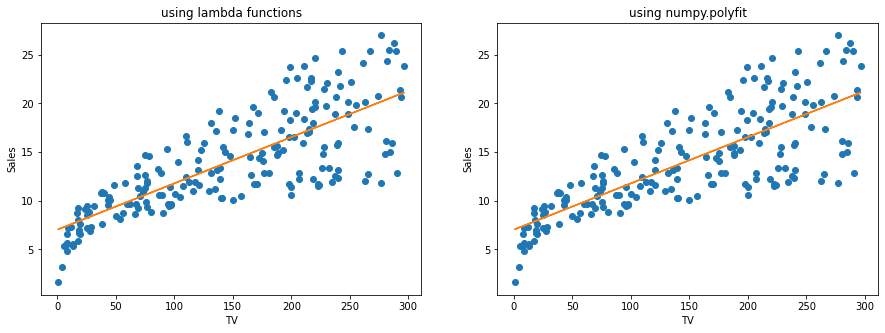

In [3]:
# define the above functions
beta_1_fun = lambda x,y: ((x-x.mean())*(y-y.mean())).sum() / ((x-x.mean())**2).sum()
beta_0_fun = lambda x,y: y.mean() - beta_1_fun(x,y)*x.mean()

# define x and y
x=df['TV']
y=df['Sales']
beta_0, beta_1 = beta_0_fun(x,y), beta_1_fun(x,y)

# this can also be done in one line:
beta_1_np, beta_0_np = np.polyfit(x, y, 1)

# plot comparison
n_plots=2
fig, ax = plt.subplots(1,n_plots,figsize=(15,5))
for i in range(n_plots):
    ax[i].plot(x, y, 'o')
    ax[i].set_xlabel('TV')
    ax[i].set_ylabel('Sales')
ax[0].set_title('using lambda functions')
ax[0].plot(x, beta_0 + beta_1*x)
ax[1].set_title('using numpy.polyfit')
ax[1].plot(x, beta_0_np + beta_1_np*x);

The model shows that an additional $1000 spent on TV advertising will see an additional 47.5 sales


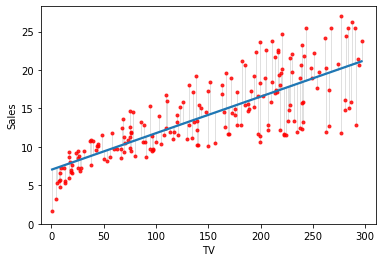

In [4]:
# seaborn automatically plots a ployfit line of any order if you want to look quickly at the relationship
sns.regplot(df.TV, df.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

# add joing vertical lines if you want:
for i in range(df.shape[0]):
    plt.plot([df.TV.iloc[i],df.TV.iloc[i]],[df.Sales.iloc[i],beta_0 + beta_1*df.TV.iloc[i]],color='#e0e0e0',linewidth=1, zorder=0)

print('The model shows that an additional $1000 spent on TV advertising will see an additional {:0.1f} sales'.format(beta_1*1000))

To show how the RSS varies for a linear model of order=1:

minimum RSS is 2.10


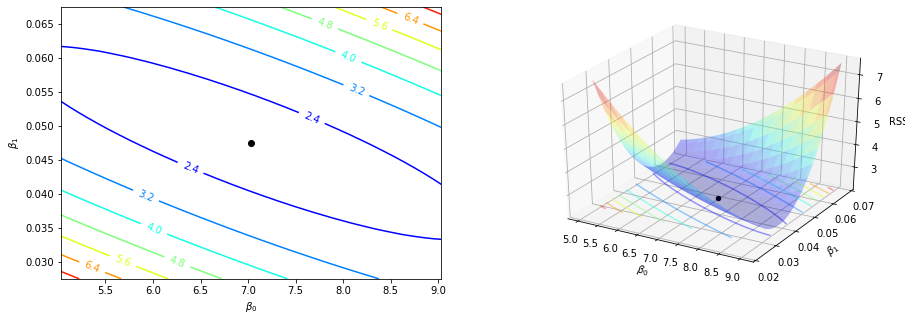

In [5]:
def make_RSS_plots(beta_0,beta_1,x,y):
    # Create grid coordinates for plotting
    B0 = np.linspace(beta_0-2, beta_0+2, 50)
    B1 = np.linspace(beta_1-0.02, beta_1+0.02, 50)
    xx, yy = np.meshgrid(B0, B1, indexing='xy')
    Z = np.zeros((B0.size,B1.size))

    # Calculate Z-values (RSS) based on grid of coefficients
    for (i,j),_ in np.ndenumerate(Z):
        Z[i,j] =((y - (xx[i,j]+x*yy[i,j]))**2).sum()/1000
    print('minimum RSS is {:0.2f}'.format(Z.min()))
    
    # make left figure a contour plot
    fig = plt.figure(figsize=(15,5))
    ax1=fig.add_subplot(1,2,1)
    CS=ax1.contour(xx, yy, Z, cmap=plt.cm.jet)
    ax1.scatter(beta_0, beta_1, c='k')
    ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
    ax1.set_xlabel(r'$\beta_0$')
    ax1.set_ylabel(r'$\beta_1$')
    # make right figure a surface over a contour plot
    ax2=fig.add_subplot(1,2,2,projection='3d')
    ax2.projection='3d'
    ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3, cmap=plt.cm.jet)
    ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.jet,
                alpha=0.4)
    ax2.scatter3D(beta_0, beta_1, Z.min(), c='k')
    ax2.set_zlabel('RSS')
    ax2.set_zlim(Z.min(),Z.max())
    ax2.set_ylim(0.02,0.07)
    ax2.set_xlabel(r'$\beta_0$')
    ax2.set_ylabel(r'$\beta_1$')

    
make_RSS_plots(beta_0,beta_1,x,y)

**Centered vs Uncentered**

The previous example was uncentered, however if we rescale the x-axis around the x mean, we still get the same gradient, however a different intercept, and the RSS graphs look more visually appealing.

When **NOT** to use centering (https://www.theanalysisfactor.com/when-not-to-center-a-predictor-variable-in-regression/):
1. If all continuous predictors have a meaningful value of 0.

2. If you have no interaction terms involving that predictor.

3. And if there are no values that are particularly meaningful.


Centering can be done easily in the scikit-learn module:

minimum RSS is 2.10


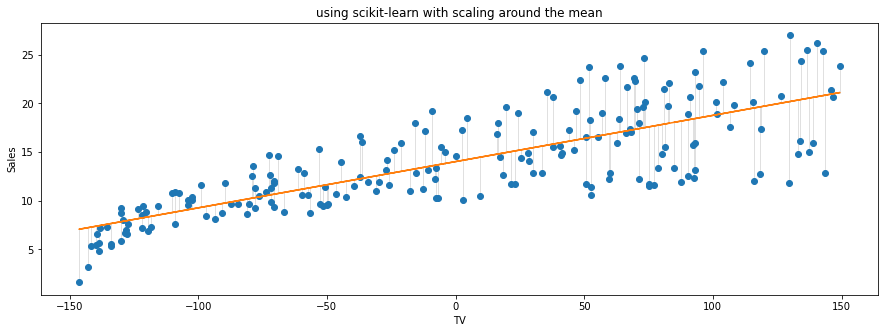

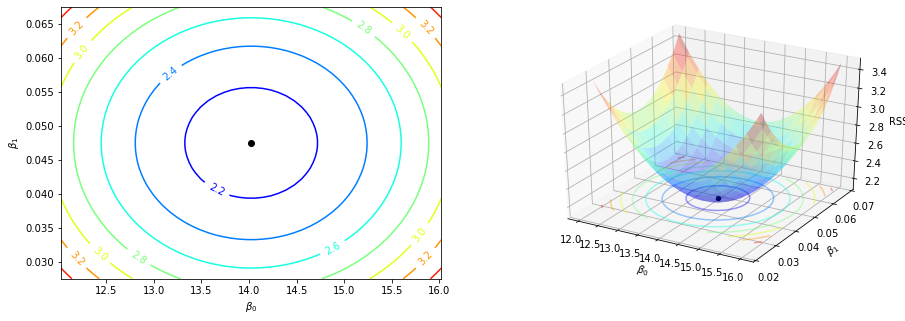

In [6]:
#define linear model
regr = skl_lm.LinearRegression()
# scale the x data
X_centering = scale(df.TV, with_mean=True, with_std=False).reshape(-1,1)
# X_no_centering = df.TV.to_numpy().reshape(-1, 1)
y = df.Sales

# fit the model
regr.fit(X_centering,y)

# plot scatter
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(X_centering,y,'o')
ax.set_xlabel('TV')
ax.set_ylabel('Sales')
ax.set_title('using scikit-learn with scaling around the mean')
ax.plot(X_centering, regr.intercept_ + regr.coef_[0]*X_centering);
# add joing vertical lines if you want:
for i in range(df.shape[0]):
    plt.plot([X_centering[i],X_centering[i]],[y.iloc[i],regr.intercept_ + regr.coef_[0]*X_centering[i]],color='#e0e0e0',linewidth=1, zorder=0)


# plot RSS plots
make_RSS_plots(regr.intercept_,regr.coef_[0],X_centering.flatten(),y)

### 3.1.2 Assessing the Accuracy of the Coefficient Estimates <a class="anchor" id="3.1.2"></a>
If the true relationship between $X$ and $Y$ is in the form:
\begin{equation}
Y=f(X)+\epsilon,
\end{equation}
then if $f$ is approximated by a linear function, the relationship is:
\begin{equation}
Y=\beta_0+\beta_1X+\epsilon.
\end{equation}


Below, in the left figure, you can see an example of how the population model (<span style="color:red">the red line</span>) \\(Y=2+3X\\) is used to generate 100 random normally distributed points, and how the linear least-squares (<span style="color:green">the green line</span>) fits. Although it is not quite the same as the true relationship, it is a pretty good representation. In the right figure we can see than for 10 different randomly generated sets of points, the linear fits (<span style="color:blue">the blue lines</span>) are a good representation everytime.

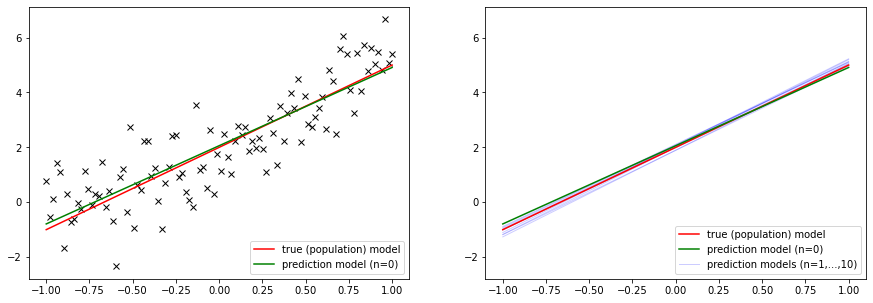

In [7]:
#error function
mu=0
sigma=1
n=100
rand_norm = lambda mu, sigma, n: sigma * np.random.randn(n) + mu

# population model
y_pop = lambda x, err: 2+3*x+err

# make 10 random normally distributed datasets from the population model
y1=[]
err=[]
x1=np.linspace(-1,1,n)
for i in range(10):
    np.random.seed(i)
    err.append(rand_norm(mu, sigma, n))
    y1.append(y_pop(x1,err[i]))
    
# left figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(x1,y1[0],'kx')
ax[0].plot([x1.min(),x1.max()],y_pop(np.array([x1.min(),x1.max()]),0),'r')
beta_0_1, beta_1_1 = beta_0_fun(x1,y1[0]), beta_1_fun(x1,y1[0])
ax[0].plot(x1, beta_0_1 + beta_1_1*x1,'g');

# right figure
ax[1].set_ylim(ax[0].get_ylim())
h1=ax[1].plot([x1.min(),x1.max()],y_pop(np.array([x1.min(),x1.max()]),0),'r')
beta_0_1, beta_1_1 = beta_0_fun(x1,y1[0]), beta_1_fun(x1,y1[0])
h2=ax[1].plot(x1, beta_0_1 + beta_1_1*x1,'g');
for i in range(1,10):
    beta_0_1, beta_1_1 = beta_0_fun(x1,y1[i]), beta_1_fun(x1,y1[i])
    h3=ax[1].plot(x1, beta_0_1 + beta_1_1*x1,'b',zorder=0,linewidth=1,alpha=0.2);
    
# legends
ax[0].legend([h1[0],h2[0]],['true (population) model','prediction model (n=0)'],loc=4);
ax[1].legend([h1[0],h2[0],h3[0]],['true (population) model','prediction model (n=0)','prediction models (n=1,...,10)'],loc=4);

For the purpose of assessing the accuracy of the coefficients in the model, it is useful to know the population mean $\mu$ of $Y$. $\mu$ is unknown, however we do we have $n$ observations from $Y$. We can use the sample mean $\bar{y}$ as a reasonable estimate for the population mean ($\hat{\mu}=\bar{y}$). In the same way we can reasonably accurately esimate $\hat{\beta_0}$ and $\hat{\beta_1}$ over a large number of unbiased observations.

We start to define useful statistical metrics to define the error we observe in the parameters.

Firstly, we want to know how far off a single estimate would be from the true value.
Generally, this is done by estimating the *standard error*, written as SE(.). For the mean this calculated by:
\begin{equation}
Var(\hat{\mu})=SE(\hat{\mu})^2=\frac{\sigma^2}{n}
\end{equation}
To see how close the estimates $\hat{\beta_0}$ and $\hat{\beta_1}$ are to the true values, we can use the following formulas:
\begin{equation}
SE(\hat{\beta_0})^2=\sigma^2 \left[\frac{1}{n}+\frac{\bar{x}^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}\right],\\
SE(\hat{\beta_1})^2=\frac{\sigma^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}},
\end{equation}
where $\sigma^2=Var(\epsilon)$. For these formulas to be strictly valid, we need to assume that the errors $\epsilon_i$ for each observation are uncorrelated with common varience $\sigma^2$.

In general, $\sigma$ is not know, but can be estimated from the data, and is known as the *residual standard error* (RSE).
\begin{equation}
RSE=\sqrt{\frac{RSS}{n-2}}
\end{equation}

SE can be used to compute *confidence intervals*. For linear regression, the 95% confidence interval for $\beta_0$ and $\beta_1$ is approximately
\begin{equation}
\hat{\beta_0} \pm 2\cdot SE(\hat{\beta_0}),\\
\hat{\beta_1} \pm 2\cdot SE(\hat{\beta_1}).
\end{equation}

In [8]:
RSE_fun = lambda RSS,n: (RSS/(n-2))**0.5
SE_beta0_fun = lambda RSS,x: (RSE_fun(RSS,len(x))**2*(1/len(x)+x.mean()**2/((x-x.mean())**2).sum()))**0.5
SE_beta1_fun = lambda RSS,x: (RSE_fun(RSS,len(x))**2/((x-x.mean())**2).sum())**0.5
CIs = lambda SE_x,x: [x-2*SE_x,x+2*SE_x]

RSS=sum([(y.iloc[i]-(beta_0 + beta_1*x.iloc[i]))**2 for i in range(len(y))])
SE_beta0=SE_beta0_fun(RSS,x)
SE_beta1=SE_beta1_fun(RSS,x)

print('SE(beta_0)={:0.4f}'.format(SE_beta0))
print('SE(beta_1)={:0.4f}'.format(SE_beta1))
print('confidence intervals for beta_0=[{:0.4f},{:0.4f}]'.format(*CIs(SE_beta0,beta_0)))
print('confidence intervals for beta_1=[{:0.4f},{:0.4f}]'.format(*CIs(SE_beta1,beta_1)))


SE(beta_0)=0.4578
SE(beta_1)=0.0027
confidence intervals for beta_0=[6.1169,7.9483]
confidence intervals for beta_1=[0.0422,0.0529]


SEs can also be used to perform *hypothesis tests* on the coefficients. The most common test has a *null hypothesis*:
\begin{equation}
H_0: \text{There is no relationship between } X \text{ and } Y\\
\text{i.e.}\quad H_0:\beta_1=0
\end{equation}
and an *alternative hypothesis*:
\begin{equation}
H_a: \text{There is some relationship between } X \text{ and } Y\\
\text{i.e.}\quad H_a:\beta_1\neq0
\end{equation}

To test $H_0$, we need to determine that $\hat{\beta_1}$ is sufficiently far from $0$ such that we can be confident that $\beta_1$ is non-zero. To do this we use $SE(\hat{\beta_1})$, as if it is small only small values of $\hat{\beta_1}$, and vice-versa. In practice, we compute a *t-statistic*:
\begin{equation}
t=\frac{\hat{\beta_1}-0}{SE(\hat{\beta_1})}
\end{equation}
which measures the number of standard deviations that $\hat{\beta_1}$ is away from $0$. We can now calculate the probability of observing a value $\geq |t|$ assuming $\beta_1=0$. We call this the *p-value*. In general, a small p-value indicates that it is unlikely that the relationship between the predictor and responce is due to chance, hence we *reject* $H_0$ - declaring that there is a relationship between $X$ and $Y$.

Typical cutoffs for rejecting $H_0$ are $5\%$ and $1\%$. The number of degress of freedom for the above example is $n-2$.

In [9]:
# calculate t and p values as above
t=beta_1/SE_beta1
p = 1 - stats.t.cdf(t,df=len(y)-2)

print('beta_1 t-statistic={:0.4f}'.format(t))
print('beta_1 p-value={:0.4f} (4 d.p.)'.format(p))

beta_1 t-statistic=17.6676
beta_1 p-value=0.0000 (4 d.p.)


The previous few steps can be easily calculated via the *statsmodel* module, as can be seen below. We can see that both $\hat{\beta_0}$ (Intercept) and $\hat{\beta_1}$ (TV) have very low p-values, hence $\beta_0 \neq 0$ and $\beta_1 \neq 0$.

In [10]:
# Table 3.1 in ISLR book
est = smf.ols('Sales ~ TV', df).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053


### 3.1.3 Assesing the Accuracy of the Model <a class="anchor" id="3.1.3"></a>
To assess the accuracy of the linear fit once $H_0$ has been rejected, we generally use **RSE** or the $R^2$ statistic (or to some extend the F-statistic which is explained more later on in [Section 3.2.2](#3.2.2)).

**RSE** is considered a measure of *lack of fit* of the model to the data. If $\hat{Y}\approx Y$ then **RSE** will be small, however if $\hat{y}$ is far from $y$ for one or more observations, the **RSE** may be large, indicating poor fit.

The $R^2$ statistic is similar to RSE but is scaled between 0 and 1, making it indepentdent to the value/units of $Y$. It is calculated using the following formula:
\begin{equation}
R^2=\frac{TSS-RSS}{TSS}=1-\frac{RSS}{TSS}
\end{equation}
where $TSS=\sum{(y_i-\bar{y})^2}$ is the *total sum of squares*. Below we can see the $R^2$ for this model was 0.61, indicating that just under two-thirds of the variability in sales is explained by a linear regression on TV.

In [11]:
def print_stat_table(smf_est):
    RSE_fun = lambda RSS,n: (RSS/(n-2))**0.5
    t = PrettyTable(['Quantity', 'Value'])
    t.add_row(['RSE', '{:0.2f}'.format(RSE_fun((smf_est.resid**2).sum(),smf_est.nobs))])
    t.add_row(['R^2', '{:0.3f}'.format(smf_est.rsquared)])
    t.add_row(['F-statistic', '{:0.1f}'.format(smf_est.fvalue)])
    print(smf_est.model.formula)
    print(t)

print_stat_table(est)


Sales ~ TV
+-------------+-------+
|   Quantity  | Value |
+-------------+-------+
|     RSE     |  3.26 |
|     R^2     | 0.612 |
| F-statistic | 312.1 |
+-------------+-------+


## 3.2 Multiple Linear Regression <a class="anchor" id="3.2"></a>
In reality we will have more than one predicter in a model, and thus we need a method to consider multiple predictors in our analysis. We can run seperate linear regressions for each predictor, e.g. for radio and newspaper (as shown below) and we can see that $1000 increase sales for radio and newspaper by 203 and 55 respectively.

In [12]:
# Table 3.3 in ISLR book
est_radio = smf.ols('Sales ~ Radio', df).fit()
print(est_radio.summary().tables[1])
print_stat_table(est_radio)
est_newspaper = smf.ols('Sales ~ Newspaper', df).fit()
print(est_newspaper.summary().tables[1])
print_stat_table(est_newspaper)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.000       8.202      10.422
Radio          0.2025      0.020      9.921      0.000       0.162       0.243
Sales ~ Radio
+-------------+-------+
|   Quantity  | Value |
+-------------+-------+
|     RSE     |  4.27 |
|     R^2     | 0.332 |
| F-statistic |  98.4 |
+-------------+-------+
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.000      11.126      13.577
Newspaper      0.0547      0.017      3.300      0.001       0.022       0.087
Sales ~ Newspaper
+-------------+-------+
|   Quantity  | Value |
+-------------+-------+
|     RSE     |  5.09 |
|     R^2     | 0.052 |
| F-statistic |  10.9 |
+-------------+-------+


However this ain't very satisfactory. Its hard to know how to make a single prediciton of sales given levels of the three advertising budgets and the three regression coefficients ignores the influence of the other two.

Instead of fitting seperate regression models for each predictor, we can instead extend the model to consider multiple predictors. For $p$ distinct predictors:
\begin{equation}
Y=\beta_0+\beta_1X_1+\beta_2X_2+\cdots+\beta_pX_p+\epsilon,
\end{equation}
i.e. for the advertising example:
\begin{equation}
Y=\beta_0+\beta_1\text{TV}+\beta_2\text{Radio}+\beta_3\text{Newspaper}+\epsilon.
\end{equation}

### 3.2.1 Estimating the Regression Coefficients <a class="anchor" id="3.2.1"></a>
As in the simple linear regression, $\beta_0,\beta_1,...,\beta_p$ must be estimated, and are via the formula:
\begin{equation}
\hat{y} = \hat{\beta_0} +\hat{\beta_1}x_1 +\hat{\beta_2}x_2 +\cdots+\hat{\beta_p}x_p.
\end{equation}
We also are still trying to minimise RSS, which now calculated by:
\begin{align}
RSS&=\sum_{i=1}^n{(y_i-\hat{y_i})^2}\\
&=\sum_{i=1}^n{(y_i-\hat{\beta_0} -\hat{\beta_1}x_{i1} -\hat{\beta_2}x_{i2} -\cdots-\hat{\beta_p}x_{ip})^2}.
\end{align}

When we run the model with TV, Radio and Newspaper, we get the results below. The following interpretations can be made:
* For a given amount of TV and Newspaper advertising, an additional $1000 spent on radio will lead to the sale of 189 units.
* The coefficients for TV and Radio are similar to their individual linear models, however Newspaper's has gone from being significantly non-zeor to around 0.86, showing that simple and multiple regressions can be significantly different.
* The reason for Newspaper having no relationship to Sales in the multiple regression model is due to the correlation between Radio and Newspaper being 0.35 (see the correlation matrix below). Therefore, when more money is spent on Radio adverts, it is also on Newspaper adverts, and thus Newspaper sales are a surrogate for Radio advertising (i.e. Newspaper gets "credit" for the effect of Radio on Sales).

In [13]:
est_newspaper = smf.ols('Sales ~ TV + Radio + Newspaper', df).fit()
print(est_newspaper.summary().tables[1])
print_stat_table(est_newspaper)

print('The correlation matix:\n',df.corr())

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
Sales ~ TV + Radio + Newspaper
+-------------+-------+
|   Quantity  | Value |
+-------------+-------+
|     RSE     |  1.68 |
|     R^2     | 0.897 |
| F-statistic | 570.3 |
+-------------+-------+
The correlation matix:
                  TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.782224
Radio      0.054809  1.000000   0.354104  0.576223
Newspaper  0.056648  0.354104   1.000000  0.228299
Sales      0.782224  0.576223   0.228299  1.000000


### 3.2.2 Some Important Questions<a class="anchor" id="3.2.2"></a>
When we perform multiple linear regression, we usually are interested in
answering a few important questions.
1. Is at least one of the predictors $X_1,X_2,\cdots,X_p$ useful in predicting
the response?
2. Do all the predictors help to explain $Y$ , or is only a subset of the
predictors useful?
3. How well does the model fit the data?
4. Given a set of predictor values, what response value should we predict,
and how accurate is our prediction?

We now address each of these questions in turn.

#### 3.2.2.1 Is There a Relationship Between the Response and Predictors?<a class="anchor" id="3.2.2.1"></a>
In the simple linear regression setting we performed a hypothesis test to determine whether $\beta_1=0$. With multiple regression the hypothesis test is as follows:
\begin{equation}
H_0:\beta_1=\beta_2=\cdots=\beta_p=0
\end{equation}
and an *alternative hypothesis*:
\begin{equation}
H_a:\text{at least one }\beta_j\text{ is non-zero}.
\end{equation}
This hypothesis test is performed by computing the *F-statistic*,
\begin{equation}
F=\frac{(TSS-RSS)/p}{RSS/(n-p-1)},
\end{equation}
and if the linear model assumptions are correct, you can show:
\begin{equation}
E\{RSS/(n-p-1)\}=\sigma^2,
\end{equation}
and if $H_0$ is true
\begin{equation}
E\{(TSS-RSS)/p\}=\sigma^2,
\end{equation}
therefore meaning that the F-statistic would be a value close to $1$.

However, if $H_a$ is true,
\begin{equation}
E\{(TSS-RSS)/p\}\gt\sigma^2,
\end{equation}
thus the F-statistic show be $\gt 1$. Therefore as the F-statistic is 570 it indicates that at least one of the advertising media must be related to sales.

**When do we reject $H_0$:**

How large the F-statistic needs to be to reject $H_0$ depends on the values of $n$ and $p$. A p-value can be calculated for any number of $n$ and $p$ via a F-distribution, and this p-value can then be used to determine whether or not we reject $H_0$ (the p-value for the above problem is very small).

If we instead want to test that a subset, $q$, of the coefficients are 0:
\begin{equation}
H_0: \beta_{p-q+1}=\beta_{p-q+2}=\cdots=\beta_p=0
\end{equation}
where for convenience we have put the variables for omission at the end of the list. We then fit a second model with all but the last $q$ and calculate the residual sum of squares for the model, calling that $RSS_0$. Then the appropriate F-satistic is
\begin{equation}
F=\frac{(RSS_0-RSS)/q}{RSS/(n-p-1)},
\end{equation}
we then can calculate the critical F-value (from the F-distribution, using $1$ and $n-p-1$) and accept/reject $H_0$ appropriately. This is called an F-test, and it determines the partial effect of adding that variable to the model.

**Can't we just use the p-values from the table instead of the F-statistic?**

No, espicially when $p$ is large. E.g. is $p=100$ and $H_0$ is true (i.e. no variable is associated with the response) then roughly 5% of the p-values will <0.05 just by chance. The F-statisic adjusts for the number of predictors in the model, and hence doesn't suffer from the same problem, i.e. if $H_0$ is true, the is only a 5% chance the F-statistic will result in a p-value <0.05 regardless the value of $n$ or $p$.

Note: the approach of using an F-statistc works when $p$ is relatively small, espicially in comparison to $n$. If $p\gt n$ then we can't fit the multiple linear regression model using least squares, so the F-statistic cannot be used, and neither can most of the other things in Chapter 3. *(When $p$ is large, some approaches such as forward selection, can be used. Higher dimensional sttings are discussed further in Chapter 6.)

#### 3.2.2.2 Deciding on Important Variables?<a class="anchor" id="3.2.2.2"></a>
Variable selection is studied extensively in Chapter 6, however, briefly:

Ideally we want to perform variable selection by trying out lots of different models, each containing a different subset of predictors, and we can use a variety of statistics to determine each model's quality, e.g.:
* Mallow's $C_p$
* Akaike information criterion (AIC)
* Bayesian infromation criterion (BIC)
* Adjusted $R^2$
We can also determine which model is best by plotting various model outputs, such as the residuals, in order to search for patterns (discussed more in Chapter 6).

As there are a total of $2^p$ models avaliable, it is not practical to try every one of them, therefore, we need an approach to considering a smaller set of models.There are 3 classical approaches for this task:
* **Forward Selection:** We begin with the *null model* (only the intercept and no predictors). We then fit $p$ simple linear regressions and add to the null model the variable that results in the lowest RSS. We then repeat this approach until some stopping rule is applied. This is a greedy approach, and might include variables early that later become redundant. Mixed selection can remedy this.
* **Backward Selection:** We start with all variables in teh model, and remove the variable with the largest p-value--that is, the variable that is the least statistically significant. The new (p-1)-variable model is fit, and the variable with the largest p-value is removed. This is repeated until some stopping rule is reached (e.g. all p-values are below some threshold). This method cannot be used if $p \gt n$.
* **Mixed Selection:** This is a combination of the previous two approaches. We start with no variables in the model, and as with forward selection, we add the variable that provides the best fit. We continue to add variables one-by-one. Of course, as we noted with the Advertising example, the p-values for variables can become larger as new predictors are added to the model. Hence, if at any point the p-value for one of the variables in the model rises above a certain threshold, then we remove that variable from the model. We continue to perform these forward and backward steps until all variables in the model have a sufficiently low p-value, and all variables outside the model would have a large p-value if added to the model.

#### 3.2.2.3 Model Fit<a class="anchor" id="3.2.2.3"></a>


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
Radio          0.1880      0.008     23.382      0.000       0.172       0.204
Sales ~ TV + Radio
+-------------+-------+
|   Quantity  | Value |
+-------------+-------+
|     RSE     |  1.68 |
|     R^2     | 0.897 |
| F-statistic | 859.6 |
+-------------+-------+


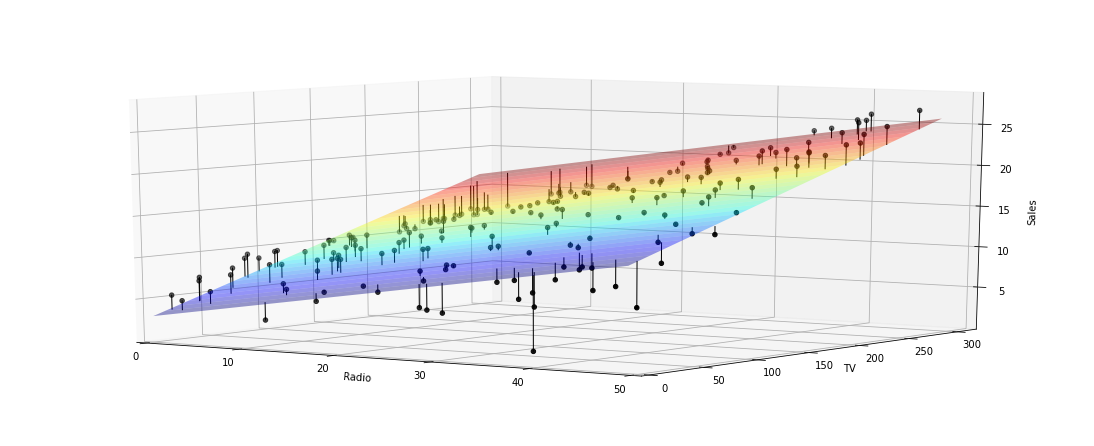

In [19]:
### make tv & radio model
est_tv_radio = smf.ols('Sales ~ TV + Radio', df).fit()
print(est_tv_radio.summary().tables[1])
print_stat_table(est_tv_radio)

# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)
B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),_ in np.ndenumerate(Z):
    Z[i,j] =(est_tv_radio.params[0] + B1[i,j]*est_tv_radio.params[2] + B2[i,j]*est_tv_radio.params[1])

# Create 3d plot
fig = plt.figure(figsize=(15,6))
ax = axes3d.Axes3D(fig)
ax.plot_surface(B1, B2, Z, rstride=10, cstride=50, alpha=0.4, cmap=plt.cm.jet)
ax.scatter3D(df.Radio, df.TV, df.Sales, c='k')
ax.view_init(10, 305)
ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(bottom=0)
ax.set_zlabel('Sales');
# add lines
for i in range(df.shape[0]):
    plt.plot([df.Radio.iloc[i],df.Radio.iloc[i]],
             [df.TV.iloc[i],df.TV.iloc[i]],
             [df.Sales.iloc[i],est_tv_radio.params[0]+df.Radio.iloc[i]*est_tv_radio.params[2]+df.TV.iloc[i]*est_tv_radio.params[1]],
             color='k',linewidth=1,zorder=0)


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7502      0.248     27.233      0.000       6.261       7.239
TV             0.0191      0.002     12.699      0.000       0.016       0.022
Radio          0.0289      0.009      3.241      0.001       0.011       0.046
TV:Radio       0.0011   5.24e-05     20.727      0.000       0.001       0.001
Sales ~ TV + Radio + (TV * Radio)
+-------------+--------+
|   Quantity  | Value  |
+-------------+--------+
|     RSE     |  0.94  |
|     R^2     | 0.968  |
| F-statistic | 1963.1 |
+-------------+--------+


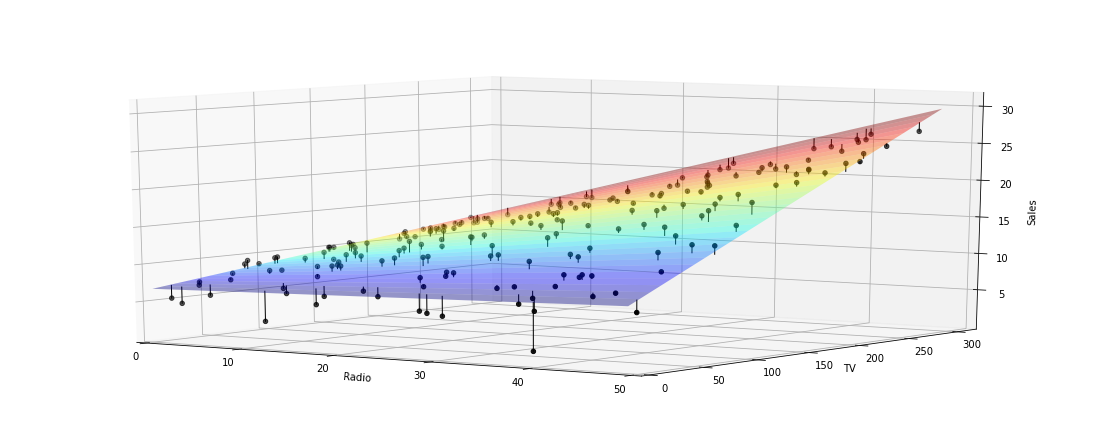

In [20]:
### make tv & radio & (TV * Radio) model
est_tv_radio = smf.ols('Sales ~ TV + Radio + (TV * Radio)', df).fit()
print(est_tv_radio.summary().tables[1])
print_stat_table(est_tv_radio)

# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)
B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),_ in np.ndenumerate(Z):
    Z[i,j] =(est_tv_radio.params[0] + B1[i,j]*est_tv_radio.params[2] + B2[i,j]*est_tv_radio.params[1] + B1[i,j]*B2[i,j]*est_tv_radio.params[3])

# Create 3d plot
fig = plt.figure(figsize=(15,6))
ax = axes3d.Axes3D(fig)
ax.plot_surface(B1, B2, Z, rstride=10, cstride=50, alpha=0.4, cmap=plt.cm.jet)
ax.scatter3D(df.Radio, df.TV, df.Sales, c='k')
ax.view_init(10, 305)
ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(bottom=0)
ax.set_zlabel('Sales');
# add lines
for i in range(df.shape[0]):
    plt.plot([df.Radio.iloc[i],df.Radio.iloc[i]],
             [df.TV.iloc[i],df.TV.iloc[i]],
             [df.Sales.iloc[i],est_tv_radio.params[0]+df.Radio.iloc[i]*est_tv_radio.params[2]+df.TV.iloc[i]*est_tv_radio.params[1]+df.TV.iloc[i]*df.Radio.iloc[i]*est_tv_radio.params[3]],
             color='k',linewidth=1,zorder=0)



